In [1]:
## Импорт бибилиотек

In [2]:
import torch
import numpy as np
import pandas as pd
import sklearn
import multiprocessing as mp
from scipy.signal import spectrogram
from biosppy.signals.ecg import hamilton_segmenter
from biosppy.signals.ecg import correct_rpeaks
import scipy
from sklearn.datasets import make_regression
from torch.utils.data import Dataset

from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import StepLR
from pytorch.model import CNN_LSTM_matrix_input
from pytorch.model import SpectrogramNetwork, ResSpectrogramNetwork
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import StepLR
from DataLoader import load_df, save_df
from DataLoader import split_long_signals
from itertools import repeat
from pytorch.data import MyDataset
from matplotlib import pyplot as plt
import multiprocessing as mp

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
## Описание датасета

In [6]:
d_l = "2"

In [7]:
train_p = np.load("train_p.npy")
test_p = np.load("test_p.npy")
val_p = np.load("val_p.npy")

In [8]:
data = load_df("tb_data")

In [9]:
train = data[data["p_id"].isin(train_p)].copy()
test = data[data["p_id"].isin(test_p)].copy()
val = data[data["p_id"].isin(val_p)].copy()

In [10]:
set(train["p_id"]).intersection(set(test["p_id"]))

set()

In [11]:
set(val["p_id"]).intersection(set(test["p_id"]))

set()

In [12]:
set(val["p_id"]).intersection(set(train["p_id"]))

set()

In [13]:
train.shape

(2648, 21)

In [14]:
test.shape

(1130, 21)

In [15]:
val.shape

(1066, 21)

In [16]:
train[train["age"] > 70]["patient_id"].nunique()

53

In [17]:
test[test["age"] > 70]["patient_id"].nunique()

23

In [18]:
val[val["age"] > 70]["patient_id"].nunique()

22

In [19]:
## Разбиение сигналов на более короткие

train = split_long_signals(train, 30000, 100000, "ECG_F", rpeaks=True)
test = split_long_signals(test, 30000, 100000, "ECG_F", rpeaks=True)
val = split_long_signals(val, 30000, 100000, "ECG_F", rpeaks=True)

  0%|          | 0/2648 [00:00<?, ?it/s]

here1


100%|██████████| 2648/2648 [00:00<00:00, 2976.40it/s]


here


100%|██████████| 1130/1130 [00:00<00:00, 15384.10it/s]

here1
here



100%|██████████| 1066/1066 [00:00<00:00, 15710.11it/s]

here1
here


In [20]:
train.target.value_counts(normalize=True)

False    0.726221
True     0.273779
Name: target, dtype: float64

In [21]:
test.target.value_counts(normalize=True)

False    0.732565
True     0.267435
Name: target, dtype: float64

In [22]:
val.target.value_counts(normalize=True)

False    0.751625
True     0.248375
Name: target, dtype: float64

In [23]:
from scipy.signal import butter, filtfilt

In [24]:
def preprocess_signal(ecg):
    fs = 1000
    Wn = 15.*2/fs;                    
    O = 2;                            
    a,b = butter(O,Wn,'low');       
    ecg1 = filtfilt(a,b,ecg);


    Wn = 5.*2/fs;                     
    a,b = butter(O,Wn,'high');      
    ecg = filtfilt(a,b,ecg1);
    return ecg

In [26]:
#train["ECG_F"] = train["ECG_F"].progress_apply(lambda x: preprocess_signal(x))
#test["ECG_F"] = test["ECG_F"].progress_apply(lambda x: preprocess_signal(x))
#val["ECG_F"] = val["ECG_F"].progress_apply(lambda x: preprocess_signal(x))

In [27]:
train.columns

Index(['Unnamed: 0', 'age', 'b_date', 'birthdate', 'c_date', 'cardiogram_id',
       'di', 'disease_info', 'gender', 'height', 'ibs', 'lenrpeaks',
       'lenrpeaks_rl', 'p_id', 'patient_id', 'profession', 'target', 'ts',
       'weight', 'ECG_F', 'rpeaks'],
      dtype='object')

In [28]:
train["rpeaks"] = train.rpeaks.apply(lambda x: np.array(x))
test["rpeaks"] = test.rpeaks.apply(lambda x: np.array(x))
test["rpeaks"] = test.rpeaks.apply(lambda x: np.array(x))

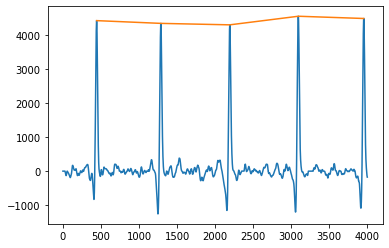

In [29]:
df = train
s_b = 0
s_len = 4000
s_ind = 0

cut_rpeaks = df["rpeaks"][s_ind][(df["rpeaks"][s_ind] <= s_len) & (df["rpeaks"][s_ind] >= s_b)]
plt.plot(range(s_b, s_len), df["ECG_F"][s_ind][s_b:s_len])
plt.plot(cut_rpeaks, [df["ECG_F"][s_ind][i] for i in cut_rpeaks])

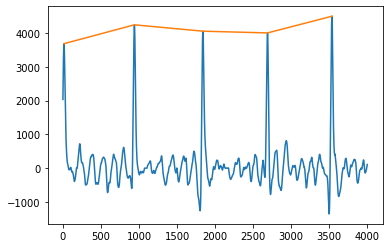

In [30]:
df = train
s_b = 0
s_len = 4000
s_ind = 1

cut_rpeaks = df["rpeaks"][s_ind][(df["rpeaks"][s_ind] <= s_len) & (df["rpeaks"][s_ind] >= s_b)]
plt.plot(range(s_b, s_len), df["ECG_F"][s_ind][s_b:s_len])
plt.plot(cut_rpeaks, [df["ECG_F"][s_ind][i] for i in cut_rpeaks])

In [31]:
def del_bad_signals(df):
    df = df.copy()
    df = df[df["lenrpeaks"] > 20].copy()
    df.reset_index(inplace=True, drop=True)
    return df

train = del_bad_signals(train)
test = del_bad_signals(test)
val = del_bad_signals(val)

In [32]:
train["SignalLen"] = train["ECG_F"].apply(lambda x: len(x))
test["SignalLen"] = test["ECG_F"].apply(lambda x: len(x))
val["SignalLen"] = val["ECG_F"].apply(lambda x: len(x))

In [33]:
train.SignalLen.max()

100000

In [34]:
train.SignalLen.min()

30459

In [35]:
train.SignalLen.mean()

98901.62390204951

In [36]:
## Разбираемся с величиной пика

In [37]:
train["diff_r_peaks"] = train["rpeaks"].apply(lambda x: np.diff(x))
test["diff_r_peaks"] = test["rpeaks"].apply(lambda x: np.diff(x))
val["diff_r_peaks"] = val["rpeaks"].apply(lambda x: np.diff(x))

In [38]:
train["max_diff_r_peaks"] = train["diff_r_peaks"].apply(lambda x: np.max(x))
test["max_diff_r_peaks"] = test["diff_r_peaks"].apply(lambda x: np.max(x))
val["max_diff_r_peaks"] = val["diff_r_peaks"].apply(lambda x: np.max(x))

In [45]:
def count_signal_points(df):
    df = df.copy()
    df["num_bad_peaks"] = df["diff_r_peaks"].apply(lambda x: len(list(filter(lambda x: (x > 2600) or (x < 300), x))))
    return df
train = count_signal_points(train)
test = count_signal_points(test)
val = count_signal_points(val)

In [43]:
train["pr_bad_peaks"] = train["num_bad_peaks"] / train["lenrpeaks"]
test["pr_bad_peaks"] = test["num_bad_peaks"] / test["lenrpeaks"]
val["pr_bad_peaks"] = val["num_bad_peaks"] / val["lenrpeaks"]

In [44]:
print(train[train["pr_bad_peaks"] > 0.55].shape)
print(test[test["pr_bad_peaks"] > 0.55].shape)
print(val[val["pr_bad_peaks"] > 0.55].shape)

(16, 26)
(0, 26)
(0, 26)


In [46]:
def del_signals_with_bad_peaks(df):
    df = df.copy()
    df = df[df["pr_bad_peaks"] <= 0.55].copy()
    df.reset_index(inplace=True, drop=True)
    return df

In [47]:
train = del_signals_with_bad_peaks(train)
test = del_signals_with_bad_peaks(test)
val = del_signals_with_bad_peaks(val)

In [45]:
print(train.shape)
print(test.shape)
print(val.shape)

(7495, 26)
(3205, 26)
(3076, 26)


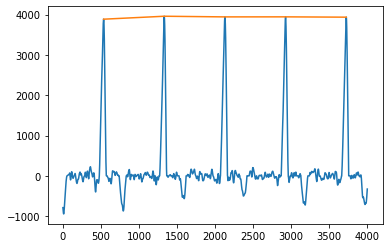

In [49]:
df = train
s_b = 0
s_len = 4000
s_ind = 1062

cut_rpeaks = df["rpeaks"][s_ind][(df["rpeaks"][s_ind] <= s_len) & (df["rpeaks"][s_ind] >= s_b)]
plt.plot(range(s_b, s_len), df["ECG_F"][s_ind][s_b:s_len])
plt.plot(cut_rpeaks, [df["ECG_F"][s_ind][i] for i in cut_rpeaks])

In [50]:
from scipy.signal import resample_poly

In [51]:
1000 / 5.0

200.0

In [52]:
##Ресемплинг сигнала
train["ECG_R"] = train.ECG_F.apply(lambda x: resample_poly(x, 1, 5)) 
test["ECG_R"] = test.ECG_F.apply(lambda x: resample_poly(x, 1, 5))
val["ECG_R"] = val.ECG_F.apply(lambda x: resample_poly(x, 1, 5))

In [53]:
train.columns

Index(['Unnamed: 0', 'age', 'b_date', 'birthdate', 'c_date', 'cardiogram_id',
       'di', 'disease_info', 'gender', 'height', 'ibs', 'lenrpeaks',
       'lenrpeaks_rl', 'p_id', 'patient_id', 'profession', 'target', 'ts',
       'weight', 'ECG_F', 'rpeaks', 'SignalLen', 'diff_r_peaks',
       'max_diff_r_peaks', 'num_bad_peaks', 'pr_bad_peaks', 'ECG_R'],
      dtype='object')

In [54]:
#train.drop(["ECG_F", "rpeaks"], axis=1, inplace=True)
#test.drop(["ECG_F", "rpeaks"], axis=1, inplace=True)
#test.drop(["ECG_F", "rpeaks"], axis=1, inplace=True)

In [55]:
train["RSignalLen"] = train["ECG_R"].apply(lambda x: len(x))
test["RSignalLen"] = test["ECG_R"].apply(lambda x: len(x))
val["RSignalLen"] = val["ECG_R"].apply(lambda x: len(x))

In [56]:
##Нормализация сигналов

In [57]:
def norm_signal(x):
    return (x - x.min()) / (x.max() - x.min()) * 2 - 1

In [58]:
train["RECG_N"] = train.ECG_R.apply(lambda x: norm_signal(x)) 
test["RECG_N"] = test.ECG_R.apply(lambda x: norm_signal(x))
val["RECG_N"] = val.ECG_R.apply(lambda x: norm_signal(x))

In [59]:
train.drop(["ECG_R"], axis=1, inplace=True)
test.drop(["ECG_R"], axis=1, inplace=True)
val.drop(["ECG_R"], axis=1, inplace=True)

In [60]:
def create_signal_image(signal, n_rows= 75, n_points = 4000, dpi=64, figsize=(17, 17), slice_size=1000):
    fig, ax = plt.subplots(nrows=n_rows, dpi=dpi,figsize=figsize )#17 17
    for k in range(n_rows):
        ax[k].axis('off')
        ax[k].plot(signal[n_points * k:n_points * (k+1)])
    fig.tight_layout()
    fig.canvas.draw()
    
    X = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    del fig
    return X

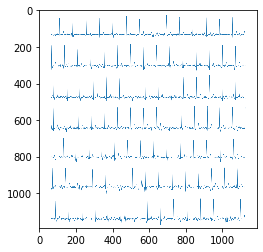

In [73]:
x = create_signal_image(image, n_rows = 7, n_points=2857, dpi=70)

In [61]:
from PIL import Image, ImageFile
import numpy as np
from torch.utils.data import Dataset
import pandas as pd
from torchvision import datasets, models, transforms
import datetime
import torchvision

In [68]:
ind=346
X = create_signal_image(train["RECG_N"][ind], n_rows = 7, n_points=2857, dpi=70)
img = X[:, 61:1128]
img = Image.fromarray(np.repeat((255 - img[:,:,3])[:,:,np.newaxis], repeats=3, axis = 2), "RGB")
simple_transform =  transforms.Compose([
                                transforms.Resize((712, 712))])
                                #transforms.ToTensor()])
                                #torchvision.transforms.Normalize(
                                #      [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
            

#img = simple_transform(img)

In [70]:
img.size

(1067, 1190)

In [63]:
img.size

(712, 712)

In [64]:
import cv2

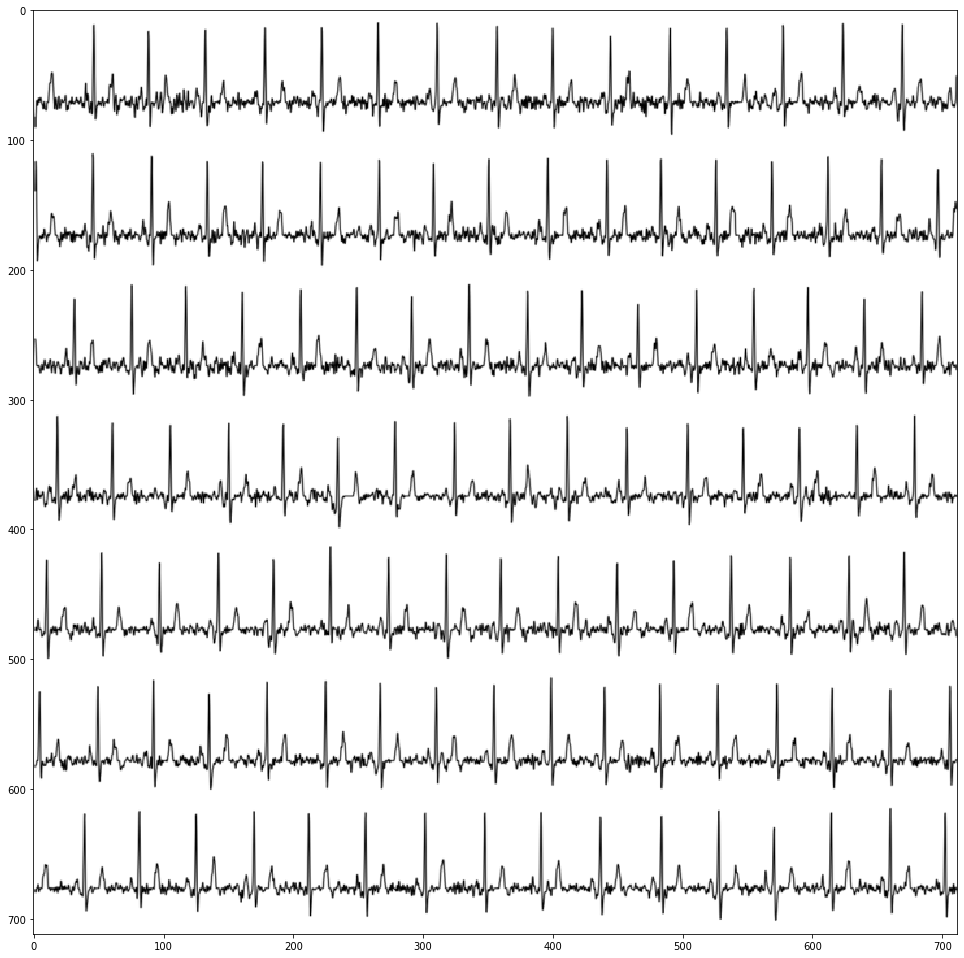

In [66]:
plt.figure(figsize=(17,17))
plt.imshow(img)
plt.savefig("signal.pdf")

In [ ]:
plt.figure(figsize=(17,17))
plt.imshow(X)

In [66]:
#plt.figure(figsize=(17,17))
#plt.imshow(X)

In [67]:
train["index"] = train.index
test["index"] = test.index
val["index"] = val.index

In [68]:
train["label"] = train.disease_info
test["label"] = test.disease_info
val["label"] = val.disease_info

In [69]:
train["path"] = train["index"].apply(lambda x:d_l + "new_train_tb_images_f"+"/"+str(x))
test["path"] = test["index"].apply(lambda x: d_l + "new_test_tb_images_f"+"/"+str(x))
val["path"] = val["index"].apply(lambda x: d_l + "new_val_tb_images_f"+"/"+str(x))

In [70]:
c = ['age',  'cardiogram_id',
       'disease_info', 'gender', 'height', 'ibs', 
       'p_id', 'patient_id', 'profession', 'target', 
       'weight',  'diff_r_peaks',
       'max_diff_r_peaks', 'num_bad_peaks', 'pr_bad_peaks', 'RSignalLen',
        'index', 'label', 'path']

In [71]:
train[c].to_csv(d_l +"new_image_train_f.csv", index=False)
test[c].to_csv(d_l + "new_image_test_f.csv", index=False)
val[c].to_csv(d_l + "new_image_val_f.csv", index=False)




In [72]:

!mkdir 1new_val_tb_images_f
!mkdir 1new_train_tb_images_f
!mkdir 1new_test_tb_images_f

mkdir: cannot create directory ‘1new_val_tb_images_f’: File exists
mkdir: cannot create directory ‘1new_train_tb_images_f’: File exists
mkdir: cannot create directory ‘1new_test_tb_images_f’: File exists


In [73]:
def create_and_save_image(image, signal_id, path):
    x = create_signal_image(image, n_rows = 7, n_points=2857, dpi=70)
    with open(path+"/"+str(signal_id)+".npy", "wb") as f:
        np.save(f, x)
    del x

In [74]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], d_l + "new_train_tb_images_f")

with mp.Pool(10) as mp_pool:
    mp_pool.map(create_image_mp, zip(train["RECG_N"].values[:1500], train["index"].values[:1500]))

In [75]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], d_l + "new_train_tb_images_f")

with mp.Pool(10) as mp_pool:
    mp_pool.map(create_image_mp, zip(train["RECG_N"].values[1500:3000], train["index"].values[1500:3000]))

In [76]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], d_l + "new_train_tb_images_f")

with mp.Pool(10) as mp_pool:
    mp_pool.map(create_image_mp, zip(train["RECG_N"].values[3000:4500], train["index"].values[3000:4500]))

In [77]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], d_l + "new_train_tb_images_f")

with mp.Pool(10) as mp_pool:
    mp_pool.map(create_image_mp, zip(train["RECG_N"].values[4500:6000], train["index"].values[4500:6000]))

In [78]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], d_l + "new_train_tb_images_f")

with mp.Pool(10) as mp_pool:
    mp_pool.map(create_image_mp, zip(train["RECG_N"].values[6000:], train["index"].values[6000:]))

In [79]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], d_l + "new_test_tb_images_f")

with mp.Pool(10) as mp_pool:
    mp_pool.map(create_image_mp, zip(test["RECG_N"].values[:1500], test["index"].values[:1500]))

In [80]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], d_l + "new_test_tb_images_f")

with mp.Pool(10) as mp_pool:
    mp_pool.map(create_image_mp, zip(test["RECG_N"].values[1500:], test["index"].values[1500:]))

In [81]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], d_l + "new_val_tb_images_f")

with mp.Pool(10) as mp_pool:
    mp_pool.map(create_image_mp, zip(val["RECG_N"].values[:1500], val["index"].values[:1500]))

In [82]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], d_l + "new_val_tb_images_f")

with mp.Pool(10) as mp_pool:
    mp_pool.map(create_image_mp, zip(val["RECG_N"].values[1500:], val["index"].values[1500:]))

In [98]:
set(train["p_id"].values).intersection(test["p_id"].values)

set()

In [99]:
set(train["p_id"].values).intersection(val["p_id"].values)

set()

In [100]:
set(test["p_id"].values).intersection(val["p_id"].values)

set()

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
val.shape

In [ ]:
def create_and_save_image2(image, signal_id, path):
    x = create_signal_image(image, n_rows = 7, n_points=2857, dpi=70, figesize=(11, 11))
    with open(path+"/"+str(signal_id)+".npy", "wb") as f:
        np.save(f, x)
    del x

In [ ]:
def resample(x):
    return resample_poly(x, 1, 90)

In [83]:
#for i, ind in tqdm(zip(train["RECG_N"].values, train["index"].values)):
#    create_and_save_image(i, ind, "train_tb_images")

In [ ]:
train.to_cs

In [ ]:
#train_images = [create_signal_image(i, n_rows = 13, n_points=1539, dpi=70) for i in train["RECG_N"]]
#val_images = [create_signal_image(i, n_rows = 13, n_points=1539, dpi=70) for i in val["RECG_N"]]
#test_images = [create_signal_image(i, n_rows = 13, n_points=1539, dpi=70) for i in test["RECG_N"]]

In [ ]:
##Ресемплинг данных

In [ ]:
## Обучение нейронной сети с предобученными весами

In [ ]:
## Обучение нейронной сети без предобученных весов

In [ ]:
## Оценка качества

In [ ]:
## Интерпретация данных